In [1]:
using Pkg
Pkg.activate(pwd());
using PGFPlots, DelimitedFiles, ApproxFun, FrameFun, BasisFunctions, DomainSets, QuadGK, LaTeXStrings
AFFun = ApproxFun.Fun 
FFFun = FrameFun.Fun

Fun (generic function with 4 methods)

In [14]:
r = .29384

function spline_function(p::Int, α::T, x::T) where T<:Real
    if x < r
        1-(-x/r+1)^p
    else
        1-((x-r)/(α-r))^p
    end
end

jump_function(b,x::T) where T<:Real = x<b ? x : T(1)

cusp = x->abs(x-r)^ELT(1//4)
dini = x->ELT(log((1//2)*abs(x-r)))^ELT(-2)
H3 = x->spline_function(3 , .5, x)
H9 = x->spline_function(9 , .5, x)
H15 = x->spline_function(15 ,.5, x)
ELT = Float64
funs = Dict(
    "Holder conv" => x->x^ELT(3//4),
    "Holder div" => x->x^ELT(1//10),
    "Holder lim" => x->x^ELT(1//2),
    "Hat" => nothing,
    "H3" => H3, 
    "H9" => H9,
    "H15" => H15,
    "Jump" => x->jump_function(.25,x),
    "Cusp" => cusp,
    "Dini" => dini);
function legendre_data(fs, Ns, eval_points)
    xl, xi, xr, xm  = eval_points
    errorl = zeros(Float64, length(Ns), length(fs))
    errorr = similar(errorl)
    errori = similar(errorl)
    errorm = similar(errorl)
    accuracy = similar(errorl)
    L = rescale(LegendrePolynomials(maximum(Ns)),0,.5)
    for (fi,f) in enumerate(fs)
        c = BasisFunctions.coefficients(approximate(L, f; discrete=false,atol=1e-12))
        for (Ni,N) in enumerate(Ns)
            F = Expansion(resize(L,N),c[1:N])
            errorl[Ni,fi] =  abs(F(xl)-f(xl))
            errori[Ni,fi] =  abs(F(xi)-f(xi))
            errorm[Ni,fi] =  abs(F(xm)-f(xm))
            errorr[Ni,fi] =  abs(F(xr)-f(xr))

        end
    end
    errorl ,errorr ,errorm ,errori
end
eval_points = [0,.29384,.5,.25]
xl, xi, xr, xm  = eval_points
Ns = [(1<<k)+1 for k in 1:9]
k = String["Holder conv", "Holder lim", "Holder div", "H3","H9","H15","Cusp", "Jump", "Dini"]
ks = String["Jump", "H3", "Holder conv", "Holder lim", "Holder div", "Cusp", "H15", "H9", "Dini"]
data_indices = [findall(ks.==ki)[] for ki in k];
indices = [findall(collect(keys(funs)).==ki)[] for ki in k];
fs = [funs[ki] for ki in k];
x_sel = 1:7;

In [15]:
if !isfile("data/right_error154")
    using FEConvergenceExperiments 
    FEConvergenceExperiments.create_data();
end
re = readdlm("data/right_error154");
le = readdlm("data/left_error154");
ie = readdlm("data/interior_error154");
pe = readdlm("data/mid_error154");

In [16]:
options = (width=250,height=100)
options_error = (width=250,height=200)

(width = 250, height = 200)

In [17]:
s1 = (style="red",mark="o")
s2 = (style="blue",mark="square")
s3 = (style="green",mark="x")
s1d = (style="red,dashed",mark="o")
s2d = (style="blue,dashed",mark="square")
s3d = (style="green,dashed",mark="x")
s = (style="black,dotted",mark="none")

(style = "black,dotted", mark = "none")

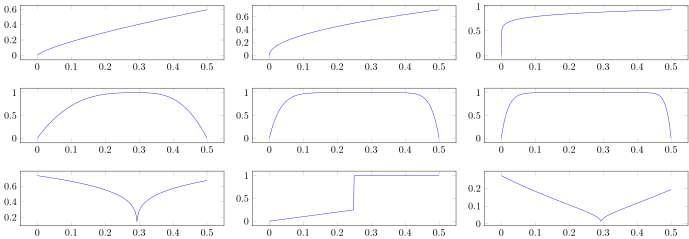

In [18]:
G = GroupPlot(3,3)
xx = collect(LinRange(0,.5,301))
for f in fs
      push!(G,Axis(Plots.Linear(xx, f.(xx),mark="none");options...))
end
G

# Splines

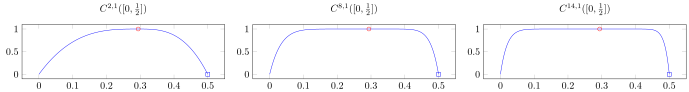

In [19]:
G = GroupPlot(3,1)
xx = collect(LinRange(0,.5,301))
titles = [L"C^{2,1}([0,\frac{1}{2}])",L"C^{8,1}([0,\frac{1}{2}])",L"C^{14,1}([0,\frac{1}{2}])"]
for (i,f) in enumerate(fs[4:6])
      push!(G,Axis([Plots.Linear(xx, f.(xx),mark="none"),
                Plots.Linear([xi], f.([xi]);s1...,onlyMarks=true),
                Plots.Linear([xr], f.([xr]);s2...,onlyMarks=true), 
                ];title=titles[i],options...))
    
end
G

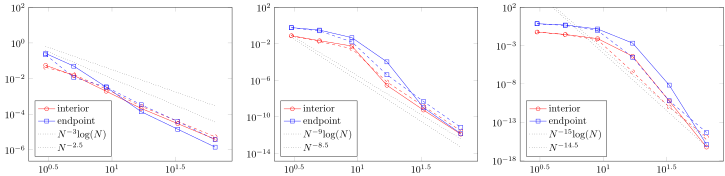

In [20]:
G = GroupPlot(3,1,groupStyle="horizontal sep = 1.5cm")
xx = collect(LinRange(0,.5,301))
lel ,ler ,lem ,lei = legendre_data([funs[key] for key in k[4:6]], Ns[x_sel], eval_points);
degrees = [3.,9.,15.]
a = [1e1,1e3, 1e11]
for (i,fi) in enumerate(data_indices[4:6])
    push!(G,Axis([Plots.Linear(Ns[x_sel], ie[x_sel,fi]; s1...,legendentry="interior"),
                    Plots.Linear(Ns[x_sel], re[x_sel,fi]; s2..., legendentry="endpoint"),
                Plots.Linear(Ns[x_sel], a[i]*Ns[x_sel].^(-degrees[i]);legendentry=latexstring("N^{-$(Int(degrees[i]))}")*"log"*latexstring("(N)"),s...),
                    Plots.Linear(Ns[x_sel], a[i]*Ns[x_sel].^(.5-degrees[i]);legendentry=latexstring("N^{-$(-.5+degrees[i])} "),s...),
                Plots.Linear(Ns[x_sel], lei[:,i];s1d...),
                    Plots.Linear(Ns[x_sel], ler[:,i];s2d...),
                ];xmode=log,ymode=log,ymax=1e2,options_error...,legendPos="south west"))
end
G

# Holder

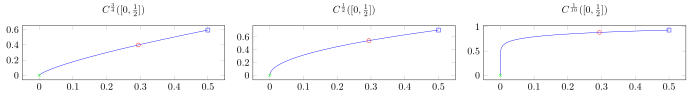

In [21]:
G = GroupPlot(3,1)
xx = collect(LinRange(0,.5,301))
titles = [L"C^\frac34([0,\frac12])",L"C^\frac12([0,\frac12])",L"C^\frac{1}{10}([0,\frac12])"]
for (i,f) in enumerate(fs[1:3])
      push!(G,Axis([Plots.Linear(xx, f.(xx),mark="none"),
                Plots.Linear([xi], f.([xi]);s1...,onlyMarks=true),
                Plots.Linear([xr], f.([xr]);s2...,onlyMarks=true), 
                Plots.Linear([xl], f.([xl]);s3...,onlyMarks=true),
                ];title=titles[i],options...))
    
end
G

In [22]:
orderstrings = [latexstring("\\mathcal O(N^{-\\frac{3}{4}}\\log(N))"),latexstring("\\mathcal O(N^{-\\frac{1}{2}}\\log(N))"), latexstring("\\mathcal O(N^{-\\frac{1}{10}}\\log(N))")]

3-element Array{LaTeXString,1}:
 L"$\mathcal O(N^{-\frac{3}{4}}\log(N))$" 
 L"$\mathcal O(N^{-\frac{1}{2}}\log(N))$" 
 L"$\mathcal O(N^{-\frac{1}{10}}\log(N))$"

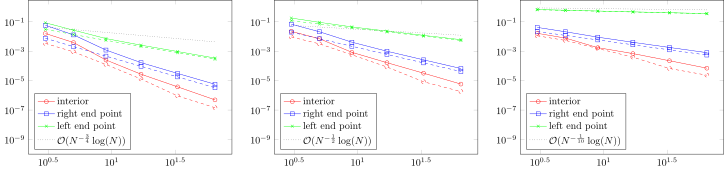

In [23]:
G = GroupPlot(3,1,groupStyle="horizontal sep = 1.5cm")
xx = collect(LinRange(0,.5,301))
lel ,ler ,lem ,lei = legendre_data([funs[key] for key in k[1:3]], Ns[x_sel], eval_points);
degreestrings = [L"\frac{3}{4}",L"\frac{1}{2}",L"\frac{1}{10}"]
degrees = [3//4,1//2,1//10]
a = [1e3,1e3,1e4]*1e-4
for (i,fi) in enumerate(data_indices[1:3])
    push!(G,Axis([Plots.Linear(Ns[x_sel], ie[x_sel,fi];s1...,legendentry="interior"),
                Plots.Linear(Ns[x_sel], re[x_sel,fi];s2...,legendentry="right end point"),
                Plots.Linear(Ns[x_sel], le[x_sel,fi];s3...,legendentry="left end point"),
                Plots.Linear(Ns[x_sel], a[i]*Ns[x_sel].^(-Float64(degrees[i]));s...,legendentry=orderstrings[i],s...),
                Plots.Linear(Ns[x_sel], lei[:,i];s1d...),
                    Plots.Linear(Ns[x_sel], ler[:,i];s2d...),
                    Plots.Linear(Ns[x_sel], lel[:,i];s3d...),
                
                ];xmode=log,ymode=log,legendPos="south west",ymin=1e-10,ymax=3e0,options_error...))
end
G

# Other

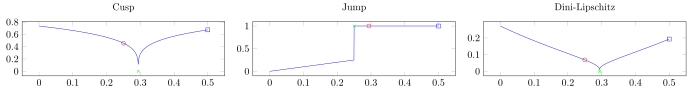

In [24]:
G = GroupPlot(3,1)
xx = collect(LinRange(0,.5,1001))
titles = ["Cusp","Jump","Dini-Lipschitz"]
for (i,f) in enumerate(fs[7:9])
    xs = (i==2) ? xm : xi
    x_i = (i==2) ? xi : xm
      push!(G,Axis([Plots.Linear(xx, f.(xx),mark="none"),
                Plots.Linear([x_i], f.([x_i]);s1...,onlyMarks=true),
                Plots.Linear([xr], f.([xr]);s2...,onlyMarks=true),
                Plots.Linear([xs], f.([xs]);s3...,onlyMarks=true),
                ];title=titles[i],options...))
    
end
G

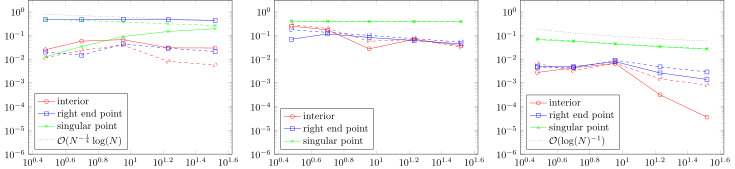

In [25]:
G = GroupPlot(3,1,groupStyle="horizontal sep = 1.5cm")
xx = collect(LinRange(0,.5,301))
lel ,ler ,lem ,lei = legendre_data([funs[key] for key in k[7:9]], Ns[x_sel[1:end-1]], eval_points);
degrees = [1/4,1/2,1/10]
for (i,fi) in enumerate(data_indices[7:9])
    es = (i==2) ? pe : ie
    e_i = (i==2) ? ie : pe
    les = (i==2) ? lem : lei
    le_i = (i==2) ? lei : lem
    A = [Plots.Linear(Ns[x_sel[1:end-1]], e_i[x_sel[1:end-1],fi];s1...,legendentry="interior"),
        Plots.Linear(Ns[x_sel[1:end-1]], re[x_sel[1:end-1],fi];s2...,legendentry="right end point"),
        Plots.Linear(Ns[x_sel[1:end-1]], es[x_sel[1:end-1],fi];s3...,legendentry="singular point")]
    if i == 1 
        push!(A,Plots.Linear(Ns[x_sel[1:end-1]], Ns[x_sel[1:end-1]].^(-1/4);s...,legendentry=latexstring("\\mathcal O(N^{-\\frac{1}{4}}\\log(N)")))
    end
    if i==3
        push!(A,Plots.Linear(Ns[x_sel[1:end-1]], 2e-1 ./ log.(Ns[x_sel[1:end-1]]);s...,legendentry=latexstring("\\mathcal O(\\log(N)^{-1})")))
    end
    push!(A, Plots.Linear(Ns[x_sel[1:end-1]], le_i[:,i];s1d...),
        Plots.Linear(Ns[x_sel[1:end-1]], ler[:,i];s2d...),
        Plots.Linear(Ns[x_sel[1:end-1]], les[:,i];s3d...))
    push!(G,Axis(A ;xmode=log,ymode=log,legendPos="south west",ymin=1e-6,ymax=3,options_error...))
end
G

# Analytic functions

In [ ]:
T = BigFloat("2.43")

In [ ]:
m = (x,T)->2(cos(pi/T*x)-cos(pi/T))/(1-cos(pi/T))-1
minv = (x,T)->T/pi*acos(.5*(cos(pi/T)*(1-x)+x+1))
function bernstein(rho,n=100)
    theta = LinRange(-0,2pi,n+1)[1:end-1]
    .5*(rho*exp.(1im*theta)+1/rho*exp.(-1im*theta))
end
function minvbernstein(rho,T,n=100)
    [-minv.(bernstein(rho,n>>1),T)..., minv.(bernstein(rho,n>>1),T)...]
end

In [ ]:
rs = map(x->1im*BigFloat(x),[".3",".6","1.5","2"]);

In [ ]:
ρ = [Float64(min(abs(cot(pi/4T)^2),abs(m(r,T)+sqrt(m(r,T)^2-1)))) for r in rs]

In [ ]:
ρ__ = -m(T,T)+sqrt(m(T,T)^2-1)

In [ ]:
GP = GroupPlot((3,1))
push!(GP, Axis([Plots.Linear(real.(minvbernstein(ρ__,T,1000)), imag.(minvbernstein(ρ__,T,1000)), style="thick", mark="none"),
            [Plots.Linear(real.(minvbernstein(ρ_,T,1000)), imag.(minvbernstein(ρ_,T,1000)), style="black",mark="none") for ρ_ in ρ[1:2]]...,
            Plots.Linear(real.(rs), imag.(rs), onlyMarks=true,mark="x")
            ]; options...))
GP

In [ ]:
using GaussQuadrature, GenericSVD, LinearAlgebra

In [ ]:
function Grammatrix(n,T::ELT) where {ELT <:AbstractFloat}
    i = map(x->x.value,ordering(FourierBasis(2n+1)))
    [k==l ? complex(ELT(2)) : ELT(2)*exp(1im*ELT(pi)*(l-k))*sin(ELT(pi)/T*(l-k))/(ELT(pi)/T*(l-k)) for k in i, l in i]
end

In [ ]:
f = (z,x)->1/(x-z)

In [ ]:
setprecision(256)
nodes, weights = jacobi(201,big(0.),big(0.))
f2 = exp
t = LinRange(-1,1,50)
ns = 1:30

errors = zeros(length(ns),length(rs))
errors2 = zeros(length(ns))
errors3 = zeros(length(ns),length(rs))
errors4 = zeros(length(ns))
for (ni,n) in enumerate(ns)
    T = BigFloat("2.43")
    F = FourierBasis(2n+1,-T,T)
    G = Grammatrix(n,T);
    u,s,v = svd(G);
    (100*eps(T) > s[end]) && (warn("Precision loss in SVD"))
    for (ri,r) in enumerate(rs)
        b = [sum(weights.*conj(F[k].(nodes)).*f.(r,nodes)) for k in 1:length(F)];
        x = v*(Diagonal(1 ./ s)*(u'*b))
        y = Expansion(F,x)
        errors[ni,ri] = maximum(abs.(y.(t)-f.(r,t)))
        errors3[ni,ri] = sqrt(abs(sum(weights.*(y.(nodes)-f.(r,nodes)).^2)))
        
    end
    b = [sum(weights.*conj(F[k].(nodes)).*f2.(nodes)) for k in 1:length(F)];
    x = v*(Diagonal(1 ./ s)*(u'*b))
    y = Expansion(F,x)
    errors2[ni] = maximum(abs.(y.(t)-f2.(t)))
    errors4[ni] = sqrt(abs(sum(weights.*(y.(nodes)-f2.(nodes)).^2)))
end

In [ ]:
s1 = (style="red",mark="o")
s2 = (style="blue",mark="square")
s3 = (style="green",mark="x")
s4 = (style="brown",mark="diamond")
s1d = (style="red,dashed",mark="o")
s2d = (style="blue,dashed",mark="square")
s3d = (style="green,dashed",mark="x")
s = (style="black,dotted",mark="none")

In [ ]:
ss = [s1,s2,s3,s4]

In [ ]:
P2 = Axis([[Plots.Linear(collect(2ns .+ 1),errors3[:,i];ss[i]...) for i in 1:size(errors,2)]...,
        Plots.Linear(collect(2ns .+ 1),errors4, style="yellow",mark="star"),
        [Plots.Linear(collect(2ns .+ 1),10*ρ_.^-ns,style="black,dashed",mark="none") for ρ_ in ρ]...,
        ],    
    ymode=log; ymin=1e-15,ymax=1e1, options_error...)

In [ ]:
P3 = Axis([[Plots.Linear(collect(2ns .+ 1),errors[:,i];ss[i]...) for i in 1:size(errors,2)]...,
        Plots.Linear(collect(2ns .+ 1),errors2,style="yellow",mark="star"),
        [Plots.Linear(collect(2ns .+ 1),30ρ_.^-ns,style="black,dashed",mark="none") for ρ_ in ρ]...,
        ],    
    ymode=log; ymin=1e-15,ymax=1e1, options_error...)

In [ ]:
GP = GroupPlot(2,1,groupStyle="horizontal sep = 1.5cm")
push!(GP, Axis([Plots.Linear(real.(minvbernstein(ρ__,T,1000)), imag.(minvbernstein(ρ__,T,1000)), style="thick", mark="none"),
            [Plots.Linear(real.(minvbernstein(ρ_,T,1000)), imag.(minvbernstein(ρ_,T,1000)), style="black",mark="none") for ρ_ in ρ[1:2]]...,
            [Plots.Linear([real.(rs[i])], [imag.(rs[i])]; ss[i]...,onlyMarks=true,mark="x",markSize=3) for i in 1:4]...
            ]; options_error...))
push!(GP, P3)
GP